<a href="https://colab.research.google.com/github/KehaoXu/CDDPM/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/root/gdrive')

Mounted at /root/gdrive


In [ ]:
# === 安装依赖 ===
!pip install -q colab_ssh --upgrade

# === 替换成你自己的 SSH 公钥（务必完整）===
your_public_key = """ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIB9q4mEILd4sHVFwgR7Qk1ZRyt9Qj9eSkfX0EYt8rNaq kehaoxu96@gmail.com"""

# === 设置 SSH 并授权免密登录 ===
from colab_ssh import launch_ssh_cloudflared
import os

# 创建 authorized_keys 并写入公钥
os.makedirs("/root/.ssh", exist_ok=True)
with open("/root/.ssh/authorized_keys", "w") as f:
    f.write(your_public_key)
os.chmod("/root/.ssh", 0o700)
os.chmod("/root/.ssh/authorized_keys", 0o600)

# 启动 SSH + cloudflared
launch_ssh_cloudflared(password="not_needed")

# 注意：launch_ssh_cloudflared 会自动打印连接地址


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/mlsp

[Errno 107] Transport endpoint is not connected: '/content/drive/MyDrive/mlsp'
/root/gdrive/MyDrive/mlsp


In [ ]:
!pip install medmnist diffusers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.8 MB/s eta 0:00:00


In [ ]:
import medmnist
print(medmnist.__version__)

3.0.2


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torch import nn, optim
from tqdm import tqdm
import numpy as np
from collections import Counter

from medmnist import BreastMNIST, INFO, Evaluator
from diffusers import UNet2DConditionModel, DDPMScheduler

import matplotlib.pyplot as plt
import os


# Load dataset

In [ ]:
data_flag = 'breastmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

In [ ]:

# 定义数据增强/预处理
data_transform = transforms.Compose([
    # transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),                # 转成Tensor
    transforms.Normalize(mean=[.5], std=[.5])  # 归一化到[-1,1]
])

size = 128

# 加载训练集
train_dataset = BreastMNIST(
    split='train',
    transform=data_transform,
    download=True,
    size = size
)

test_dataset = BreastMNIST(
    split='test',
    transform=data_transform,
    download=True,
    size = size
)

# 用DataLoader封装
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)
# train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*16, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*16, shuffle=False)


100%|██████████| 11.0M/11.0M [00:01<00:00, 5.82MB/s]


image shape: torch.Size([16, 1, 128, 128])
label shape: torch.Size([16, 1])


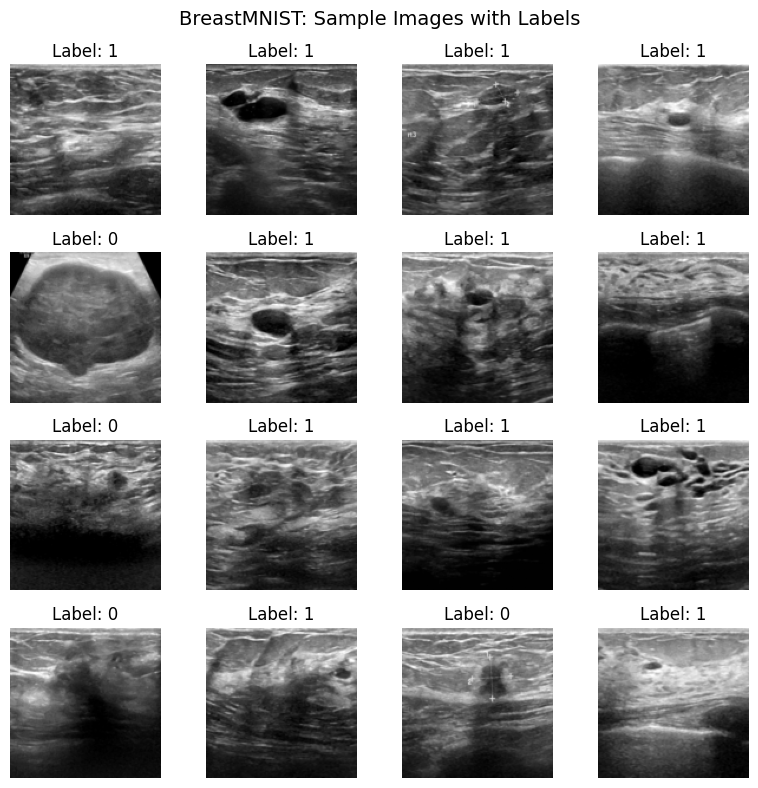

In [ ]:
# 取一个batch看看
images, labels = next(iter(train_loader))
print("image shape:", images.shape)
print("label shape:", labels.shape)

image = images.squeeze()
la = labels.squeeze()

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img = image[i].squeeze().cpu().numpy()           # [28, 28]
    label = int(la[i])                            # 0:bad, 1:good
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.suptitle("BreastMNIST: Sample Images with Labels", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:

# 提取标签
labels = [int(label) for _, label in train_dataset]

# 统计数量
label_counts = Counter(labels)
total = len(labels)
percent = np.zeros(2) # label ratio

# 打印结果
for label, count in sorted(label_counts.items()):
    percent[label] = 100 * count / total
    print(f"Label {label}: {count} samples ({percent[label]:.2f}%)")

Label 0: 147 samples (26.92%)
Label 1: 399 samples (73.08%)


/tmp/ipython-input-2207045744.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels = [int(label) for _, label in train_dataset]


# DDPM


## Train

In [ ]:
# checkpoint_dir = "./checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, train_losses, path):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "train_losses": train_losses,
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at: {path}")

def load_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    train_losses = checkpoint["train_losses"]
    print(f"Checkpoint loaded from: {path} | Resume from epoch {epoch + 1}")
    return epoch, train_losses



In [ ]:
def train_diffusion_model(
    model,
    label_emb,
    noise_scheduler,
    train_loader,
    checkpoint_dir = "./checkpoints",
    resume_path="./checkpoints/latest.pt",
    EPOCHS= None,
    lr=1e-4,
    save_every=10,
    device="cuda"):

    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    # EPOCHS = 0
    train_losses = []

    if resume_path and os.path.exists(resume_path):
        start_epoch, train_losses = load_checkpoint(resume_path, model, optimizer)
    else:
        start_epoch = 0

    # train_losses = np.ones(EPOCHS)       # 每个 epoch 的平均 loss

    for epoch in range(start_epoch, start_epoch + EPOCHS):
        batch_losses = []       # 当前 epoch 所有 batch 的 loss

        pbar = tqdm(train_loader)
        for images, labels in pbar:  # 正确方式：直接解包 tuple
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            noise = torch.randn_like(images)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (images.size(0),), device=device).long()
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

            encoder_hidden_states = label_emb(labels).unsqueeze(1)  # [B, 1, 128]

            noise_pred = model(noisy_images, timesteps, encoder_hidden_states).sample

            loss = loss_fn(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            avg_batch_loss = np.mean(batch_losses) # current average loss

            pbar.set_description(f"Epoch {epoch+1} | Avg_Loss: {avg_batch_loss:.4f}")

        train_losses.append(np.mean(batch_losses)) # epoch loss

        if (epoch + 1) % save_every == 0:
            save_checkpoint(model, optimizer, epoch + 1, train_losses, f"{checkpoint_dir}/epoch_{epoch+1}.pt")

    save_checkpoint(model, optimizer, epoch, train_losses, f"{checkpoint_dir}/latest.pt")  # always keep latest


In [ ]:

model = UNet2DConditionModel(
    sample_size=size,
    in_channels=1,
    out_channels=1,
    block_out_channels=(64, 128, 128),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
    cross_attention_dim=128,
    num_class_embeds=None,
).to("cuda")


In [ ]:

num_classes = 2          # BreastMNIST 是二分类
embedding_dim = 128      # 要和 UNet 里的 cross_attention_dim 对齐

label_emb = nn.Embedding(num_classes, embedding_dim).to("cuda") # label embedding

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)  # noise schedule

In [ ]:
## train
train_diffusion_model(
    model = model,
    label_emb = label_emb,
    noise_scheduler = noise_scheduler,
    train_loader = train_loader,
    checkpoint_dir = "./checkpoints",
    resume_path= None,
    EPOCHS=10,
    lr=1e-4,
    save_every=10,
    device="cuda"
)

Epoch 1 | Avg_Loss: 0.2244: 100%|██████████| 35/35 [01:21<00:00,  2.34s/it]
Epoch 2 | Avg_Loss: 0.0564:  43%|████▎     | 15/35 [00:38<00:50,  2.55s/it]


KeyboardInterrupt: 

Checkpoint loaded from: ./checkpoints/latest.pt | Resume from epoch 10


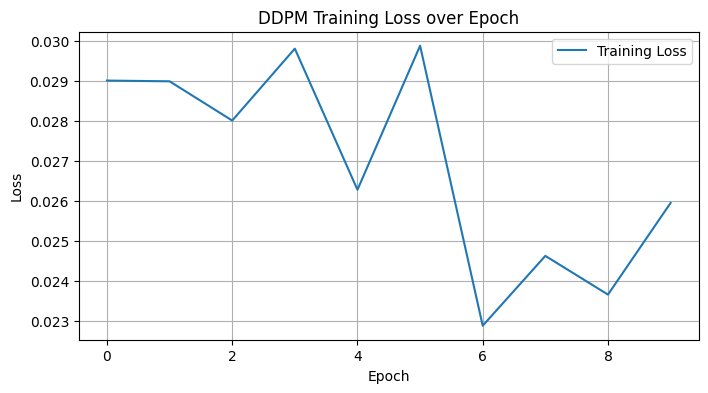

In [ ]:
## load model and plot
resume_path="./checkpoints/latest.pt"
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

if resume_path and os.path.exists(resume_path):
    start_epoch, train_losses = load_checkpoint(resume_path, model, optimizer)

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("DDPM Training Loss over Epoch")
plt.grid(True)
plt.legend()
plt.show()


## Generate

In [ ]:
def generate_samples(
    model,
    label_emb,
    noise_scheduler,
    label_ratio,
    n_channels,
    size,
    num_samples = 100,
    batch_size=16,
    device="cuda",
    save_dir="generated_imgs"
    ):

    model.eval()

    os.makedirs(save_dir, exist_ok=True) # create folder

    all_imgs = []
    all_labels = []

    # 根据比例生成标签
    labels_list = []
    for label, ratio in enumerate(label_ratio):
        count = int(num_samples * ratio)
        labels_list.extend([label] * count)

    # 补齐数量（如由于 int 向下取整）
    while len(labels_list) < num_samples:
        labels_list.append(list(label_ratio.keys())[0])  # 补第一个类

    labels = torch.tensor(labels_list, device=device)
    labels = labels[torch.randperm(len(labels))] # 随机打乱

    global_idx = 0

    for i in range(0, num_samples, batch_size):
        batch_labels = labels[i:i+batch_size].to(device)
        x_gen = torch.randn((len(batch_labels), n_channels, size, size), device=device)

        print(x_gen.shape)
        print(batch_labels.shape)

        encoder_hidden_states = label_emb(batch_labels).unsqueeze(1)  # [B, 1, 128]

        for t in tqdm(reversed(range(noise_scheduler.num_train_timesteps))):
            t_tensor = torch.full((len(batch_labels),), t, device=device, dtype=torch.long)
            with torch.no_grad():
                noise_pred = model(x_gen, t_tensor, encoder_hidden_states).sample

            x_gen = noise_scheduler.step(noise_pred, t, x_gen).prev_sample

        x_gen = (x_gen.clamp(-1, 1) + 1) / 2  # 反归一化为 [0,1]

        for j in range(x_gen.size(0)):
            img = x_gen[j, 0].cpu().numpy()  # shape: [H, W]
            label = batch_labels[j].item()
            path = os.path.join(save_dir, f"sample_{global_idx:04d}_label{label}.png")
            plt.imsave(path, img, cmap='gray')
            global_idx += 1

        all_imgs.append(x_gen.cpu())
        all_labels.append(batch_labels.cpu())

    return torch.cat(all_imgs, dim=0), torch.cat(all_labels, dim=0)


In [ ]:
x_gen, y_gen = generate_samples(
    model,
    label_emb,
    noise_scheduler,
    label_ratio= percent,
    n_channels = n_channels,
    size = size,
    num_samples = 50,
    batch_size=16,
    device="cuda"
    )

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
1000it [11:24,  1.46it/s]


torch.Size([16, 1, 128, 128])
torch.Size([16])


1000it [11:24,  1.46it/s]


torch.Size([16, 1, 128, 128])
torch.Size([16])


720it [08:11,  1.46it/s]

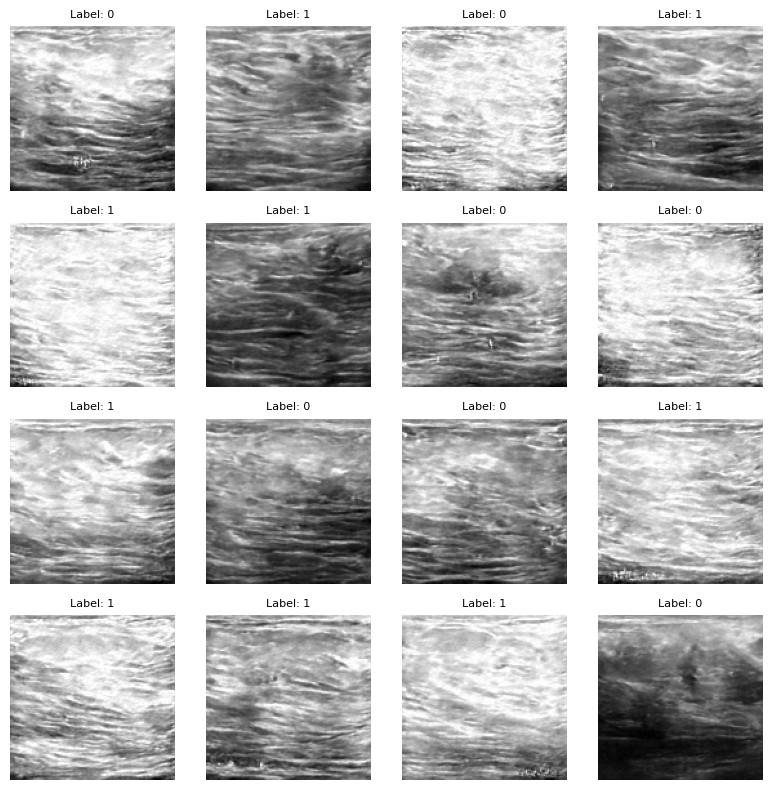

In [ ]:
# 可视化
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    row, col = divmod(i, 4)  # 计算行列索引
    axs[row, col].imshow(x_gen[i, 0].cpu(), cmap='gray')
    axs[row, col].set_title(f"Label: {y_gen[i].item()}", fontsize=8)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(x_gen.shape)
print(y_gen.shape)

torch.Size([64, 1, 128, 128])
torch.Size([64])


In [ ]:

# 确保数据是 float tensor，且维度一致
# x_gen = x_gen.detach().cpu().float()          # (B, 1, 128, 128)
# y_gen = y_gen.reshape(-1,1).detach().cpu().long()     # (B,)

x_gen = torch.tensor(x_gen, dtype=torch.float32)
y_gen = torch.tensor(y_gen, dtype=torch.long) # or float32 if needed

# 构造一个新 dataset
gen_dataset = TensorDataset(x_gen, y_gen)

# 拼接到原始 train_dataset 后面
train_dataset_augmented = ConcatDataset([train_dataset, gen_dataset])

train_loader_aug = DataLoader(train_dataset_augmented, batch_size=16, shuffle=True)
# train_loader_aug_at_eval = DataLoader(train_dataset_augmented, batch_size=2*16, shuffle=False)


/tmp/ipython-input-455070843.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen = torch.tensor(x_gen, dtype=torch.float32)


In [ ]:
# 获取一个 batch（train_loader）
inputs1, targets1 = next(iter(train_loader))
inputs2, targets2 = next(iter(train_loader_aug))

print("==== train_loader ====")
print("Type:", type(inputs1), type(targets1))
print("Input shape:", inputs1.shape, "| Target shape:", targets1.shape)
print("Input dtype:", inputs1.dtype, "| Target dtype:", targets1.dtype)

print("\n==== train_loader_aug ====")
print("Type:", type(inputs2), type(targets2))
print("Input shape:", inputs2.shape, "| Target shape:", targets2.shape)
print("Input dtype:", inputs2.dtype, "| Target dtype:", targets2.dtype)

# 类型一致性断言（可选）
assert type(inputs1) == type(inputs2), "Input types differ!"
assert type(targets1) == type(targets2), "Target types differ!"
assert inputs1.dtype == inputs2.dtype, "Input dtypes differ!"
assert targets1.dtype == targets2.dtype, "Target dtypes differ!"


==== train_loader ====
Type: <class 'torch.Tensor'> <class 'torch.Tensor'>
Input shape: torch.Size([16, 1, 128, 128]) | Target shape: torch.Size([16, 1])
Input dtype: torch.float32 | Target dtype: torch.int64

==== train_loader_aug ====
Type: <class 'torch.Tensor'> <class 'torch.Tensor'>
Input shape: torch.Size([16, 1, 128, 128]) | Target shape: torch.Size([16, 1])
Input dtype: torch.float32 | Target dtype: torch.int64


In [ ]:

images, labels = next(iter(train_loader_aug))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Images dtype:", images.dtype)
print("Labels dtype:", labels.dtype)

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Images dtype:", images.dtype)
print("Labels dtype:", labels.dtype)

Images shape: torch.Size([16, 1, 128, 128])
Labels shape: torch.Size([16, 1])
Images dtype: torch.float32
Labels dtype: torch.int64
Images shape: torch.Size([16, 1, 128, 128])
Labels shape: torch.Size([16, 1])
Images dtype: torch.float32
Labels dtype: torch.int64


# CNN classifier

In [ ]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 29 * 29, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [ ]:
# evaluation

def test(model, data_loader, device='cuda', task=None, split=None):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    # data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


# print('==> Evaluating ...')
# test('train')
# test('test')

In [ ]:
def train_classifier(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    device='cuda',
    num_epochs=5,
    task=None,
    ):

    model = model.to(device)

    for epoch in range(num_epochs):
        # train_correct = 0
        # train_total = 0
        # test_correct = 0
        # test_total = 0

        model.train()

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

        for inputs, targets in pbar:
            # print("inputs:", type(inputs), inputs.shape, inputs.dtype, inputs.device)
            # print("targets:", type(targets), targets.shape, targets.dtype, targets.device)
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward + backward + optimize
            optimizer.zero_grad()
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                loss = criterion(outputs, targets)
            else:
                targets = targets.squeeze().long()
                loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
    # return model
        test(model, train_loader, 'cuda', task, 'train')
        test(model, test_loader, 'cuda', task, 'test')

In [ ]:
model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train_classifier(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device="cuda",
    num_epochs=5,
    task=task,
)

# test(model, test_loader, 'cuda', task, 'test')


Epoch 0: 100%|██████████| 35/35 [00:00<00:00, 116.37it/s]


train  auc: 0.834  acc:0.806
test  auc: 0.809  acc:0.782


Epoch 1: 100%|██████████| 35/35 [00:00<00:00, 127.58it/s]


train  auc: 0.910  acc:0.775
test  auc: 0.846  acc:0.769


Epoch 2: 100%|██████████| 35/35 [00:00<00:00, 117.88it/s]


train  auc: 0.966  acc:0.872
test  auc: 0.867  acc:0.814


Epoch 3: 100%|██████████| 35/35 [00:00<00:00, 129.16it/s]


train  auc: 0.996  acc:0.929
test  auc: 0.880  acc:0.801


Epoch 4: 100%|██████████| 35/35 [00:00<00:00, 115.93it/s]


train  auc: 0.998  acc:0.842
test  auc: 0.878  acc:0.788


In [ ]:
model = Net(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train_classifier(
    model=model,
    train_loader=train_loader_aug,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device="cuda",
    num_epochs=5,
    task=task,
)


Epoch 0:  18%|█▊        | 7/39 [00:00<00:00, 106.89it/s]

inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.Size([16, 1]) torch.int64 cpu
inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.Size([16, 1]) torch.int64 cpu
inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.Size([16, 1]) torch.int64 cpu
inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.Size([16, 1]) torch.int64 cpu
inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.Size([16, 1]) torch.int64 cpu
inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.Size([16, 1]) torch.int64 cpu
inputs: <class 'torch.Tensor'> torch.Size([16, 1, 128, 128]) torch.float32 cpu
targets: <class 'torch.Tensor'> torch.S

TypeError: expected Tensor as element 1 in argument 0, but got numpy.ndarray